# 22 Autoencoder

In [58]:
import torch 
import torch.nn as nn 
import torch.optim as optim 
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
import pytorch_lightning as pl 
from pytorch_lightning import Trainer

In [35]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5), (0.5))
# ])
transform = transforms.ToTensor()
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size=64, shuffle=True)

In [7]:
dataiter = iter(data_loader)
images, labels = dataiter.next()
torch.min(images), torch.max(images)

(tensor(0.), tensor(1.))

In [49]:
class Autoencoder(pl.LightningModule):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # N, 784 
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128), # N, 128
            nn.ReLU(),
            nn.Linear(128, 64), 
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 2) # N, 2
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128), 
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [50]:
model = Autoencoder()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criteria = nn.MSELoss()

In [51]:
nepochs = 12
outputs = []
for epoch in range(nepochs):
    for images, _ in data_loader:
        images = images.reshape(-1, 1, 28*28)
        new_img = model(images)
        loss = criteria(images, new_img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch: {epoch+1}, loss: {loss.item():.4f}')
    outputs.append((epoch, images, new_img))

Epoch: 1, loss: 0.0450
Epoch: 2, loss: 0.0516
Epoch: 3, loss: 0.0456
Epoch: 4, loss: 0.0454
Epoch: 5, loss: 0.0409
Epoch: 6, loss: 0.0415
Epoch: 7, loss: 0.0425
Epoch: 8, loss: 0.0444
Epoch: 9, loss: 0.0484
Epoch: 10, loss: 0.0453
Epoch: 11, loss: 0.0424
Epoch: 12, loss: 0.0375


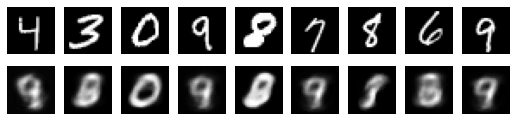

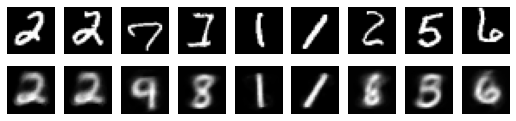

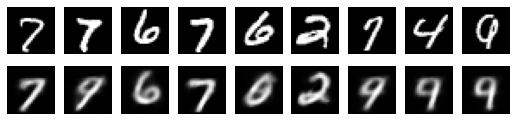

In [52]:
for k in [0, 6, 11]:
    plt.figure(figsize=(9, 2))
    plt.axis('off')
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.axis('off')
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break 
        plt.subplot(2, 9, 9 + i + 1)
        plt.axis('off')
        item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])

## CNN

In [63]:
class AutoencoderCNN(pl.LightningModule):
    def __init__(self):
        super(AutoencoderCNN, self).__init__()
        # N, 1, 28, 28 
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7), # N, 64, 1, 1
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), 
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [64]:
model = AutoencoderCNN()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criteria = nn.MSELoss()

In [65]:
nepochs = 5
outputs = []
for epoch in range(nepochs):
    for images, _ in data_loader:
        new_img = model(images)
        loss = criteria(images, new_img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch: {epoch+1}, loss: {loss.item():.4f}')
    outputs.append((epoch, images, new_img))

Epoch: 1, loss: 0.0088
Epoch: 2, loss: 0.0045
Epoch: 3, loss: 0.0037
Epoch: 4, loss: 0.0036
Epoch: 5, loss: 0.0032


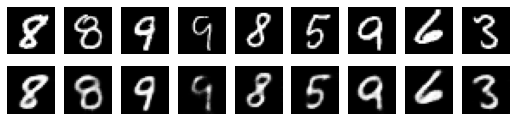

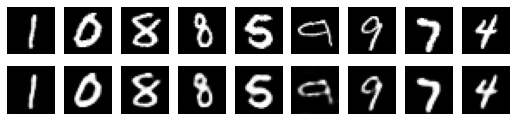

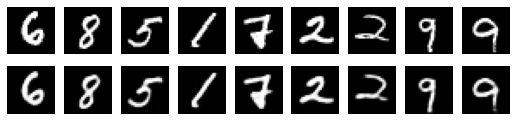

In [67]:
for k in [0, 2, 4]:
    plt.figure(figsize=(9, 2))
    plt.axis('off')
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.axis('off')
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break 
        plt.subplot(2, 9, 9 + i + 1)
        plt.axis('off')
        plt.imshow(item[0])

## Lightning

In [14]:
class Autoencoder(pl.LightningModule):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # N, 784 
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128), # N, 128
            nn.ReLU(),
            nn.Linear(128, 64), 
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3) # N, 3
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128), 
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def train_dataloader(self):
        transform = transforms.ToTensor()
        mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        data_loader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size=64,
                                                  shuffle=True, num_workers=8)
        return data_loader 
    
    def training_step(self, batch, batch_index):
        images, labels = batch 
        images = images.reshape(-1, 1, 28*28)
        new_img = self(images)
        loss = F.mse_loss(images, new_img)
        return {'loss': loss}
    
    def val_dataloader(self):
        transform = transforms.ToTensor()
        mnist_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
        data_loader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size=64,
                                                  shuffle=False, num_workers=8)
        return data_loader
    
    def validation_step(self, batch, batch_index):
        images, labels = batch 
        images = images.reshape(-1, 1, 28*28)
        new_img = self(images)
        loss = F.mse_loss(images, new_img)
        return {'loss': loss}
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=1e-5)

In [15]:
model = Autoencoder()
trainer = Trainer(max_epochs=4, auto_lr_find=True)
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 109 K 
1 | decoder | Sequential | 110 K 
---------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]